In [1]:
import sys
sys.path.append('d:\\dev\\mt5-python')

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time, timedelta
from modules import TradingStrategy

In [2]:
def plot_df(df, buy_entries=[], buy_exits=[], sell_entries=[], sell_exits=[]):
    plt.figure(figsize=(16,4))
    plt.plot(df['close'], label='Close', alpha=0.7)
    
    # Plotting buy and sell points with specified markers and colors
    plt.scatter(df.index[buy_entries], df['close'].iloc[buy_entries], marker='^', color='g', label='Buy Entry', alpha=0.7)
    plt.scatter(df.index[buy_exits], df['close'].iloc[buy_exits], marker='v', color='darkgreen', label='Buy Exit', alpha=0.7)
    plt.scatter(df.index[sell_entries], df['close'].iloc[sell_entries], marker='v', color='r', label='Sell Entry', alpha=0.7)
    plt.scatter(df.index[sell_exits], df['close'].iloc[sell_exits], marker='^', color='darkred', label='Sell Exit', alpha=0.7)
    
    plt.title('Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
def filter_dataframe_by_date(df, start_date=None, end_date=None):
    datetime_column_name = 'time'
    if start_date:
        df = df[df[datetime_column_name] >= start_date]
    if end_date:
        df = df[df[datetime_column_name] <= end_date]
    return df

In [5]:
def summarize_trade_results(trade_results, strategy_name):
    total_win = sum(x for x in trade_results['profits'] if x > 0)
    total_loss = -sum(x for x in trade_results['profits'] if x < 0)
    profit_factor = total_win / total_loss if total_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0

    # Print and log the statistics
    lines = [
        f"Strategy: {strategy_name}",
        f"Total trade Num: {len(trade_results['profits'])}",
        f"Total profit: {format(sum(trade_results['profits']), ',.2f')}",
        f"Profit Factor: {profit_factor:.2f}",
        f"Long Trade Num: {len(trade_results['long_profits'])}",
        f"Long Win Rate: {long_win_rate:.2f}",
        f"Short Trade Num: {len(trade_results['short_profits'])}",
        f"Short Win Rate: {short_win_rate:.2f}\n"
    ]
    
    for line in lines:
        print(line)
        logging.info(line)

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Plot the results
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
# Initialize portfolio state
def init_portfolio():
    return {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0,
        'trailing_stop': 0,
        'take_profit': None,
        'stop_loss': None,
        'profit': 0
    }

def trade_logic(symbol, df, trade_conditions_func):
    df = df.reset_index(drop=True)

    trade_results = {
        'profits': [],
        'long_profits': [],
        'short_profits': [],
        'buy_entries': [],
        'buy_exits': [],
        'sell_entries': [],
        'sell_exits': []
    }

    portfolio = init_portfolio()

    for i in range(0, len(df)):
        profit = 0

        action = trade_conditions_func(symbol, df, i, portfolio)

        if portfolio['position'] is not None:
            if action == 'exit_long':
                trade_results['profits'].append(portfolio['profit'])
                trade_results['long_profits'].append(portfolio['profit'])
                trade_results['buy_exits'].append(i)
                portfolio = init_portfolio()

            if action == 'exit_short':
                trade_results['profits'].append(portfolio['profit'])
                trade_results['short_profits'].append(portfolio['profit'])
                trade_results['sell_exits'].append(i)
                portfolio = init_portfolio()

            else:
                trade_results['profits'].append(profit)
        
        elif action == 'entry_long':
            trade_results['profits'].append(profit)
            trade_results['buy_entries'].append(i)
            portfolio['position'] = 'long'

        elif action == 'entry_short':
            trade_results['profits'].append(profit)
            trade_results['sell_entries'].append(i)
            portfolio['position'] = 'short'

        else:
            trade_results['profits'].append(profit)

    return trade_results

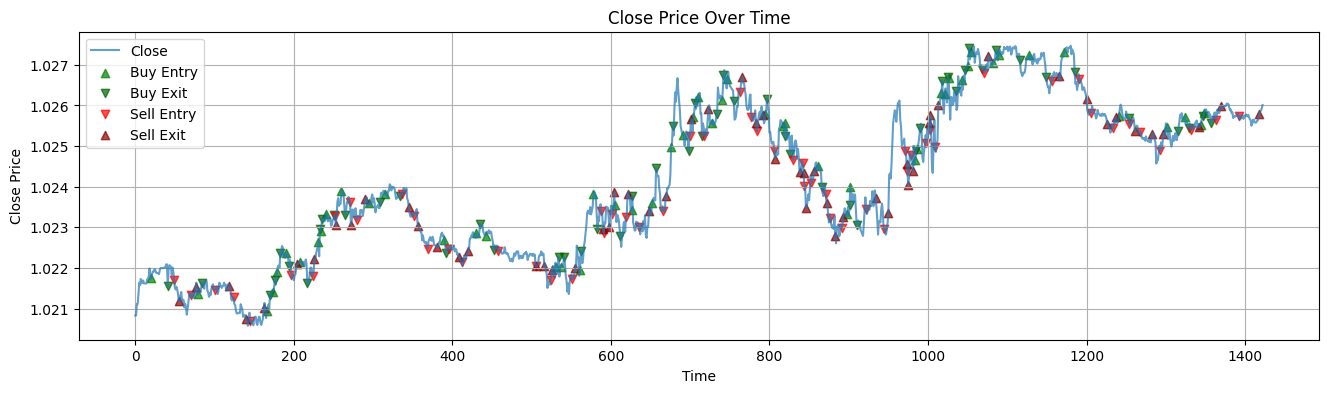

Strategy: trend line trade
Total trade Num: 1476
Total profit: -9,840.46
Profit Factor: 0.00
Long Trade Num: 53
Long Win Rate: 0.00
Short Trade Num: 57
Short Win Rate: 0.00



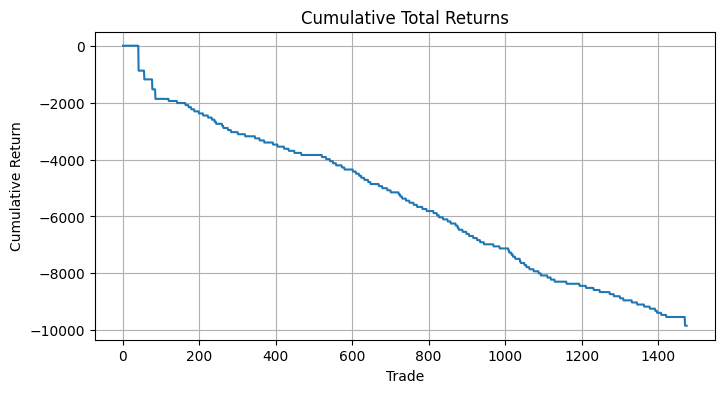

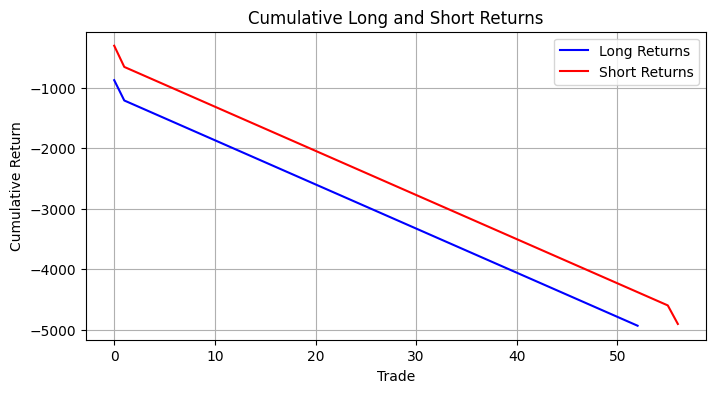

In [6]:
# Backtest
file_name = '../csv/EURUSD_1_20220801_to_20230801.csv'
symbol = 'EURUSD'

df = pd.read_csv(file_name)

# Generate the log filename with current timestamp
log_filename = datetime.now().strftime('../log/%Y-%m-%d-%H-%M.log')

if __name__ == '__main__':
    # Logging configuration
    logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(message)s')
    logging.info(f'{file_name}\n')

    strategy = TradingStrategy(allow_short=True)

    # Filter data by date if required
    start_date = None
    end_date = None
    start_date = "2022-08-01"
    end_date = "2022-08-02"
    df = filter_dataframe_by_date(df, start_date, end_date)

    trade_conditions = [
        (strategy.trade_conditions_func, "trend line trade"),
    ]

    # Execute the trade logic
    for trade_condition, description in trade_conditions:
        result = trade_logic(symbol, df, trade_condition)
        
        # Plot using modified plot function
        plot_df(df, result['buy_entries'], result['buy_exits'], result['sell_entries'], result['sell_exits'])
        summarize_trade_results(result, description)


In [7]:
def backtest_with_strategy(settings, data):
    strategy = TradingStrategy(params=settings)
    results = trade_logic("EURUSD", data, strategy.trade_conditions_func)
    total_profit = sum(results['profits'])
    return total_profit

risk_reward_ratios = np.arange(0.5, 3.0, 0.5)
stop_loss_points = np.arange(0.00005, 0.00105, 0.00005)
periods = np.arange(100, 500, 50)
distances = np.arange(5, 200, 10)
pivot_counts = np.arange(2, 5, 1)

# Define a function to run the loop for different settings and print results
def loop_search_for_profit(data):
    for risk_reward_ratio in risk_reward_ratios:
        for stop_loss_point in stop_loss_points:
            for period in periods:
                for distance in distances:
                    for pivot_count in pivot_counts:
                        settings = {
                            'risk_reward_ratio': risk_reward_ratio,
                            'stop_loss_point': stop_loss_point,
                            'period': period,
                            'distance': distance,
                            'pivot_count': pivot_count
                        }
                        
                        profit = backtest_with_strategy(settings, data)
                        if profit > 0:
                            print(f"Profit: {profit:.2f}, Settings: {settings}")


# Backtest
file_name = '../csv/EURUSD_1_20220801_to_20230801.csv'
symbol = 'EURUSD'

df = pd.read_csv(file_name)

# Filter data by date if required
start_date = None
end_date = None
start_date = "2022-08-01"
end_date = "2022-08-02"
df = filter_dataframe_by_date(df, start_date, end_date)

# Execute the loop search using the day's data (Aug 1st, 2022)
loop_search_for_profit(df)

Profit: -2102.34, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period': 100, 'distance': 50, 'pivot_count': 2}
Profit: -2102.34, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period': 100, 'distance': 50, 'pivot_count': 3}
Profit: -2102.34, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period': 100, 'distance': 50, 'pivot_count': 4}
Profit: -2102.34, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period': 100, 'distance': 50, 'pivot_count': 5}
Profit: -1883.37, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period': 100, 'distance': 60, 'pivot_count': 2}
Profit: -1883.37, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period': 100, 'distance': 60, 'pivot_count': 3}
Profit: -1883.37, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period': 100, 'distance': 60, 'pivot_count': 4}
Profit: -1883.37, Settings: {'risk_reward_ratio': 1.0, 'stop_loss_point': 5e-05, 'period':